In [5]:
#my intent is to use this notebook to pull together all the finished pieces of data and handle score/metric calculations here

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import statistics as stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12,7]
title_fontsize=14

import json

#load data
Master = pd.read_csv('consolidated_master_revised_2023_v2.csv')
#Master=Master[Master.season!=2018] #remove Pat's terrible season to demonstrate what happens
full_rs_matchups_df=pd.read_csv('full_rs_matchups_w_is_drafted thru 2023.csv') #this file is created separately
full_seasons_draft_df = pd.read_csv('full_seasons_draft_df thru 2023.csv') #load draft data - this is compiled in a separate notebook
full_faab=pd.read_csv('faab_thru_2023.csv')
full_playoffs=pd.read_csv('all_playoffs_thru_2023_revised v2.csv')

In [18]:
#functions
def create_metric_dict(metrics_dict, values, metric, ascending):
    metric_dict = {}
    df = pd.DataFrame(values,columns=['value']).sort_values(by=['value'],ascending=ascending).drop_duplicates().reset_index(drop=True)
    if metric not in ['rs_points_against','playoff_points_against']:
        variances = []
        for index, row in df.iterrows():
            if index == 0:
                variances.append(0)
            else:
                variance = abs(df.iloc[index-1]['value'] - row['value'])
                variances.append(variance)

        sum_variance = sum(variances)
        #alternate way I decided against because it would create too much variance (ironically) in scores
        #variance_percents = []
        #for v in variances:
        #    variance_percents.append(v/sum_variance)
        for i in range(len(variances)):
            #metric_percent = sum(variance_percents[i:])
            #metric_dict[df.iloc[i]['value']] = metrics_dict[metric] * metric_percent
            if i ==0:
                #assign the max value
                metric_dict[df.iloc[i]['value']] = metrics_dict[metric]
                last_value = metrics_dict[metric]
            else:
                percent_variance = variances[i] / sum_variance
                next_value = last_value - (last_value * percent_variance)
                metric_dict[df.iloc[i]['value']] = next_value
                last_value = next_value
    else:
        #handle points against
        for value in df.value:
            metric_dict[value] = value * metrics_dict[metric]
        
    return metric_dict

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def calculate_composite_ranks(Master,start_year,pre_managers,recency_bonus,recency_window,Metrics_dict,use_model_weights,
                              manager_controlled_overall_weight,win_percentages_overall_weight,points_against_overall_weight,season_rank_weight):

    #weights informed by trained regression models
    manager_controlled_weights={
        'rs_points':.151,
        'playoff_points':.103,
        'draft_efficiency':.035,
        'faab_efficiency':.023,
        'undrafted_savvy':.014
    }
    win_percentage_weights={
        'rs_win_percentage':.209,
        'playoff_win_percentage':.129
    }
    points_against_weights={
        'rs_points_against':.146,
        'playoff_points_against':.033
    }

    invert_manager_uncontrolled_weights=False #I had added this initially because I didn't like how points against were being deprioritized, but it is not necessary now
    
    #get metric proportions from model feature weights
    if use_model_weights:
        metrics_dict={}
        available_weight=100-season_rank_weight
        #print(f'available_weight: {available_weight}')
        #print('Features managers have control over:')
        sum_manager_controlled=sum(manager_controlled_weights.values())
        #print(f'sum_manager_controlled: {sum_manager_controlled}')
        for k in manager_controlled_weights:
            proportion = manager_controlled_weights[k] / sum_manager_controlled
            points_weight = proportion*manager_controlled_overall_weight*available_weight
            #print(f'{k}: {proportion} - {points_weight}')
            metrics_dict[k]=points_weight
        #print('\nFeatures managers do not have control over:')
        sum_win_percents_weights=sum(win_percentage_weights.values())
        #print(f'sum_win_percents_weights: {sum_win_percents_weights}')
        i=1
        for k in win_percentage_weights:
            if invert_manager_uncontrolled_weights:
                inverted_key=list(win_percentage_weights.keys())[-i]
                proportion = proportion = win_percentage_weights[inverted_key] / sum_win_percents_weights
            else:
                proportion = win_percentage_weights[k] / sum_win_percents_weights
            points_weight = proportion*win_percentages_overall_weight*available_weight
            #print(f'{k}: {proportion} - {points_weight}')
            metrics_dict[k]=points_weight
            i=i+1
        #now do it for points against features
        sum_points_against_weights=sum(points_against_weights.values())
        #print(f'sum_points_against_weights: {sum_points_against_weights}')
        i=1
        for k in points_against_weights:
            if invert_manager_uncontrolled_weights:
                inverted_key=list(points_against_weights.keys())[-i]
                proportion = proportion = points_against_weights[inverted_key] / sum_points_against_weights
            else:
                proportion = points_against_weights[k] / sum_points_against_weights
            points_weight = proportion*points_against_overall_weight*available_weight
            #print(f'{k}: {proportion} - {points_weight}')
            metrics_dict[k]=points_weight
            i=i+1
        #add season_rank
        metrics_dict['season_rank']=season_rank_weight
    else:
        metrics_dict=Metrics_dict

    #print out weights for convenience
    weights_df=pd.DataFrame()
    weights_df['metric']=metrics_dict.keys()
    weights_df['weight']=metrics_dict.values()
    weights_df.sort_values(by=['weight'],inplace=True,ascending=False)
    if use_model_weights:
        print('Using MODEL-derived metric weights:')
    else:
        print('Using USER-defined metric weights:')
    weights_df.sort_values(by=['weight'],inplace=True,ascending=False)
    for index, row in weights_df.iterrows():
        metric=row['metric']
        weight=row['weight']
        print(f'    {metric}: {round(weight,3)}')
    print('')

    #check weights sum to 100
    sum_weights=round(sum(list(metrics_dict.values())))
    if sum_weights != 100:
        print(f'Sum Metric Weights: {sum_weights}')
        print('WARNING: Metric weights do not sum to 100. To help manage relative metric weighting, consider modifying weights.\n')

    seasons = list(Master.season.drop_duplicates())
    latest_season = Master.season.max()

    #add necessary features to master
    Master['rs_win_percentage'] = Master.wins/(Master.losses + Master.wins) #note: this does not account for ties

    #need to add playoff matches because I've neglected to already have that feature
    playoff_match_counts =[]
    for index, row in Master.iterrows():
        number_managers = Master[Master.season==row['season']].shape[0]
        if math.isnan(row['playoff_seed']):
            #playoff seed is null
            playoff_matches = np.nan
        else:
            if number_managers == 6:
                if row['playoff_seed'] <= 4:
                    playoff_matches = 2
                else:
                    playoff_matches = 1
            elif number_managers == 8:
                if row['playoff_seed'] <= 2:
                    playoff_matches = 2
                elif row['playoff_seed'] <= 6:
                    if row['rank'] in [5,6]:
                        playoff_matches = 2
                    else:
                        playoff_matches = 3
                else:
                    playoff_matches = 1
            elif number_managers == 10:
                if row['playoff_seed'] <= 2:
                    playoff_matches = 2
                elif row['playoff_seed'] <= 6:
                    if row['rank'] in [5,6]:
                        playoff_matches = 2
                    else:
                        playoff_matches = 3
                else:
                    playoff_matches = 2
        playoff_match_counts.append(playoff_matches)
    Master['playoff_matches'] = playoff_match_counts
    Master['avg_playoff_points'] = Master['revised_p_score'] / Master['playoff_matches'] #revised p_score accounts for manual fixes for 2020 and 2022
    Master['playoff_win_percent'] = Master['playoff_wins'] / Master['playoff_matches']

    #need to add playoff_points_AGAINST
    sum_p_points_against = []
    for index, row in Master.iterrows():
        manager_id = int(row['team_key'].split('.')[-1])
        season = row['season']
        #playoff_df = pd.read_csv(f'{season}_pre_playoffs.csv')
        playoff_df = full_playoffs[full_playoffs.season==season]
        playoff_df = playoff_df[playoff_df.score != '–']
        playoff_df['score'] = playoff_df['score'].astype(float)
        #playoff_opponents = playoff_df[playoff_df.manager_id == manager_id].opponent_id.drop_duplicates()
        opponent_scores = playoff_df[playoff_df.opponent_id==manager_id].score
        sum_p_points_against.append(sum(opponent_scores))
    Master['p_points_against'] = sum_p_points_against
    Master['avg_playoff_points_against'] = Master['p_points_against'] / Master['playoff_matches']

    #season data dict that we will use for aggregations by season
    #reminder why we need this: it is (primarily) so we can see relative performance of a specific season to reward recency bonus
    season_data_dict ={}
    for season in Master.season.drop_duplicates():
        season_dict = {}
        season_df = Master[Master.season == season]
        #stuff for win percents
        win_percents = season_df.rs_win_percentage
        win_percent_mean = sum(win_percents) / len(win_percents)
        win_percent_stdev = stats.stdev(win_percents)
        season_dict['win_percent_mean'] = win_percent_mean
        season_dict['win_percent_stdev'] = win_percent_stdev

        #stuff for rs_points
        season_points = season_df.points_for
        rs_points_mean = sum(season_points) / len(season_points)
        rs_points_stdev = stats.stdev(season_points)
        season_dict['rs_points_mean'] = rs_points_mean
        season_dict['rs_points_stdev'] = rs_points_stdev

        #stuff for rs_points_against
        season_points_against = season_df.points_against
        rs_points_against_mean = sum(season_points_against) / len(season_points_against)
        rs_points_against_stdev = stats.stdev(season_points_against)
        season_dict['rs_points_against_mean'] = rs_points_against_mean
        season_dict['rs_points_against_stdev'] = rs_points_against_stdev

        #stuff for playoff win percents
        playoff_win_percents = season_df[season_df.playoff_win_percent.notnull()].playoff_win_percent
        p_win_percents_mean = sum(playoff_win_percents) / len(playoff_win_percents)
        p_win_percents_stdev = stats.stdev(playoff_win_percents)
        season_dict['p_win_percents_mean'] = p_win_percents_mean
        season_dict['p_win_percents_stdev'] = p_win_percents_stdev

        #stuff for playoff points
        avg_p_points = season_df[season_df.avg_playoff_points.notnull()].avg_playoff_points
        p_points_mean = sum(avg_p_points) / len(avg_p_points)
        p_points_stdev = stats.stdev(avg_p_points)
        season_dict['p_points_mean'] = p_points_mean
        season_dict['p_points_stdev'] = p_points_stdev

        #stuff for playoff points against
        avg_p_points_against = season_df[season_df.avg_playoff_points_against >0].avg_playoff_points_against
        p_points_against_mean = sum(avg_p_points_against) / len(avg_p_points_against)
        p_points_against_stdev = stats.stdev(avg_p_points_against)
        season_dict['p_points_against_mean'] = p_points_against_mean
        season_dict['p_points_against_stdev'] = p_points_against_stdev

        season_data_dict[season] = season_dict


    final_score_dfs=[]
    for iter in range(latest_season-start_year+1):
        print(f'Calculating data thru {start_year+iter}')
        master=Master[Master.season<=(start_year+iter)]
        season_managers=intersection(list(master.manager),pre_managers)
        #season managers approach only works for us so long as each next season does not include fewer pre_managers than year before

        #variable governing whether we will get the raw values together, we should only do this in the most recent year
        if master.season.max() == Master.season.max():
            compile_raw_values=True
            raw_seasons=[]
            raw_managers=[]
            raw_metrics=[]
            raw_values=[]
        else:
            compile_raw_values=False

        #---------------------REGULAR SEASON WIN PERCENTAGE-------------------------------------
        win_percent_dict = {}
        raw_win_percent_dict ={}
        for manager in season_managers:
            win_percent_values = []
            manager_df = master[master.manager == manager]
            for index, row in manager_df.iterrows():
                if row['season'] < (latest_season - recency_window):
                    win_percent_values.append(row['rs_win_percentage'])
                else:
                    #recent season so it gets bonus
                    win_percent_z_score = (row['rs_win_percentage'] - season_data_dict[row['season']]['win_percent_mean']) / season_data_dict[row['season']]['win_percent_stdev']
                    score_modifier = win_percent_z_score * recency_bonus
                    modified_score = (win_percent_z_score + score_modifier) * season_data_dict[row['season']]['win_percent_stdev'] + season_data_dict[row['season']]['win_percent_mean']
                    win_percent_values.append(modified_score)
                if compile_raw_values:
                    raw_seasons.append(row['season'])
                    raw_managers.append(manager)
                    raw_metrics.append('avg_rs_win_percent')
                    raw_values.append(row['rs_win_percentage'])
            avg_win_percent = sum(win_percent_values) / len(win_percent_values)
            win_percent_dict[manager] = avg_win_percent

        win_percent_score_dict = create_metric_dict(metrics_dict,win_percent_dict.values(),'rs_win_percentage',False)

        #create df for final scores, add first metric
        final_scores_df = pd.DataFrame(index=win_percent_dict.keys(),data=win_percent_dict.values(),columns=['avg_rs_win_percent'])
        final_scores_df['rs_win_percent_score'] = final_scores_df.avg_rs_win_percent.map(win_percent_score_dict)

        #---------------------REGULAR SEASON POINTS FOR-----------------------------
        rs_points_z_scores_dict = {}
        for manager in season_managers:
            manager_z_scores = []
            manager_df = master[master.manager==manager]
            for index, row in manager_df.iterrows():
                z_score = (row['points_for'] - season_data_dict[row['season']]['rs_points_mean']) / season_data_dict[row['season']]['rs_points_stdev']
                if row['season'] < (latest_season - recency_window):
                    manager_z_scores.append(z_score)
                else:
                    modified_score = z_score * (1 + recency_bonus)
                    manager_z_scores.append(modified_score)
                if compile_raw_values:
                    raw_seasons.append(row['season'])
                    raw_managers.append(manager)
                    raw_metrics.append('rs_points')
                    raw_values.append(z_score)
            avg_rs_points_z_score = sum(manager_z_scores) / len(manager_z_scores)
            rs_points_z_scores_dict[manager] = avg_rs_points_z_score

        points_for_dict = create_metric_dict(metrics_dict,rs_points_z_scores_dict.values(),'rs_points',False)
        final_scores_df['rs_points_z_score'] = final_scores_df.index.map(rs_points_z_scores_dict)
        final_scores_df['rs_points_score'] = final_scores_df.rs_points_z_score.map(points_for_dict)

        #-----------------------REGULAR SEASON POINTS AGAINST-------------------------
        rs_points_against_z_scores_dict = {}
        for manager in season_managers:
            manager_z_scores = []
            manager_df = master[master.manager==manager]
            for index, row in manager_df.iterrows():
                z_score = (row['points_against'] - season_data_dict[row['season']]['rs_points_against_mean']) / season_data_dict[row['season']]['rs_points_against_stdev']
                if row['season'] < (latest_season - recency_window):
                    manager_z_scores.append(z_score)
                else:
                    modified_score = z_score * (1 + recency_bonus)
                    manager_z_scores.append(modified_score)
                if compile_raw_values:
                    raw_seasons.append(row['season'])
                    raw_managers.append(manager)
                    raw_metrics.append('rs_points_against')
                    raw_values.append(z_score)
            avg_rs_points_against_z_score = sum(manager_z_scores) / len(manager_z_scores)
            rs_points_against_z_scores_dict[manager] = avg_rs_points_against_z_score

        points_against_dict = create_metric_dict(metrics_dict,rs_points_against_z_scores_dict.values(),'rs_points_against',True)
        final_scores_df['rs_points_against_z_score'] = final_scores_df.index.map(rs_points_against_z_scores_dict)
        final_scores_df['rs_points_against_score'] = final_scores_df.rs_points_against_z_score.map(points_against_dict)

        #-----------------------PLAYOFF WINS------------------------
        playoff_wins_dict = {}
        for manager in season_managers:
            playoff_win_percents = []
            manager_df = master[master.manager==manager]
            for index, row in manager_df.iterrows():
                if not math.isnan(row['playoff_win_percent']):
                    if row['season'] < (latest_season - recency_window):
                        playoff_win_percents.append(row['playoff_win_percent'])
                    else:
                        playoff_win_percent_z_score = (row['playoff_win_percent'] - season_data_dict[row['season']]['p_win_percents_mean']) / season_data_dict[row['season']]['p_win_percents_stdev']
                        score_modifier = playoff_win_percent_z_score * recency_bonus
                        modified_score = (playoff_win_percent_z_score + score_modifier) * season_data_dict[row['season']]['p_win_percents_mean'] + season_data_dict[row['season']]['p_win_percents_stdev']
                        playoff_win_percents.append(modified_score)
                    if compile_raw_values:
                        raw_seasons.append(row['season'])
                        raw_managers.append(manager)
                        raw_metrics.append('playoff_win_percentage')
                        raw_values.append(row['playoff_win_percent'])
                avg_rs_points_against_z_score = sum
            playoff_wins_dict[manager] = sum(playoff_win_percents) / len(playoff_win_percents)

        playoff_win_percent_score_dict = create_metric_dict(metrics_dict,playoff_wins_dict.values(),'playoff_win_percentage',False)
        final_scores_df['avg_p_win_percent'] = final_scores_df.index.map(playoff_wins_dict)
        final_scores_df['p_win_percent_score'] = final_scores_df.avg_p_win_percent.map(playoff_win_percent_score_dict)

        #-----------------------PLAYOFF POINTS-----------------------
        playoff_points_dict = {}
        for manager in season_managers:
            avg_playoff_points = []
            manager_df = master[master.manager==manager]
            for index, row in manager_df.iterrows():
                if not math.isnan(row['avg_playoff_points']):
                    z_score_playoff_points = (row['avg_playoff_points'] - season_data_dict[row['season']]['p_points_mean']) / season_data_dict[row['season']]['p_points_stdev']
                    if row['season'] < (latest_season - recency_window):
                        avg_playoff_points.append(z_score_playoff_points)
                    else:
                        modified_score = z_score_playoff_points * (1 + recency_bonus)
                        avg_playoff_points.append(modified_score)
                    if compile_raw_values:
                        raw_seasons.append(row['season'])
                        raw_managers.append(manager)
                        raw_metrics.append('playoff_points')
                        raw_values.append(z_score_playoff_points)
            playoff_points_dict[manager] = sum(avg_playoff_points) / len(avg_playoff_points)
        playoff_points_score_dict = create_metric_dict(metrics_dict,playoff_points_dict.values(),'playoff_points',False)
        final_scores_df['p_points_z_score'] = final_scores_df.index.map(playoff_points_dict)
        final_scores_df['p_points_score'] = final_scores_df.p_points_z_score.map(playoff_points_score_dict)

        #-----------------------PLAYOFF POINTS AGAINST--------------------
        p_points_against_z_scores_dict = {}
        for manager in season_managers:
            manager_z_scores = []
            manager_df = master[master.manager==manager]
            for index, row in manager_df.iterrows():
                if not math.isnan(row['avg_playoff_points']):
                    z_score = (row['avg_playoff_points_against'] - season_data_dict[row['season']]['p_points_against_mean']) / season_data_dict[row['season']]['p_points_against_stdev']
                    if row['season'] < (latest_season - recency_window):
                        manager_z_scores.append(z_score)
                    else:
                        modified_score = z_score * (1 + recency_bonus)
                        manager_z_scores.append(modified_score)
                    if compile_raw_values:
                        raw_seasons.append(row['season'])
                        raw_managers.append(manager)
                        raw_metrics.append('playoff_points_against')
                        raw_values.append(z_score)
            avg_p_points_against_z_score = sum(manager_z_scores) / len(manager_z_scores)
            p_points_against_z_scores_dict[manager] = avg_p_points_against_z_score

        p_points_against_dict = create_metric_dict(metrics_dict,p_points_against_z_scores_dict.values(),'playoff_points_against',True)
        final_scores_df['p_points_against_z_score'] = final_scores_df.index.map(p_points_against_z_scores_dict)
        final_scores_df['p_points_against_score'] = final_scores_df.p_points_against_z_score.map(p_points_against_dict)

        #-----------------------WEIGHTED RANK-----------------------
        rank_weights_dict = {
            6: {
            1:15,
            2:10,
            3:7,
            4:4,
            5:1,
            6:0
            },
            8: {
            1:18,
            2:13,
            3:10,
            4:7,
            5:5,
            6:4,
            7:1,
            8:0
            },
            10: {
            1:20,
            2:15,
            3:12,
            4:9,
            5:7,
            6:6,
            7:3,
            8:2,
            9:1,
            10:0
            }
        }

        weighted_rank_stdevs_dict = {}
        for k in rank_weights_dict.keys():
            stdev = stats.stdev(rank_weights_dict[k].values())
            weighted_rank_stdevs_dict[k] = stdev

        weighted_rank_dict = {}
        for manager in season_managers:
            manager_weighted_ranks = []
            for index, row in master[master.manager==manager].iterrows():
                number_managers = master[master.season==row['season']].shape[0]
                raw_weighted_rank = rank_weights_dict[number_managers][row['rank']]
                if row['season'] < (latest_season - recency_window):
                    manager_weighted_ranks.append(raw_weighted_rank)
                else:
                    #apply recency bonus
                    avg_weights = sum(rank_weights_dict[number_managers].values()) / number_managers
                    z_score_weighted_rank = (raw_weighted_rank - avg_weights) / weighted_rank_stdevs_dict[number_managers]
                    score_modifier = z_score_weighted_rank * recency_bonus
                    modified_score = (z_score_weighted_rank + score_modifier) * weighted_rank_stdevs_dict[number_managers] + avg_weights
                    manager_weighted_ranks.append(modified_score)
                if compile_raw_values:
                    raw_seasons.append(row['season'])
                    raw_managers.append(manager)
                    raw_metrics.append('season_rank')
                    raw_values.append(raw_weighted_rank)
            weighted_rank_dict[manager] = sum(manager_weighted_ranks) / len(manager_weighted_ranks)

        weighted_rank_score_dict = create_metric_dict(metrics_dict,weighted_rank_dict.values(),'season_rank',False)
        final_scores_df['weighted_rank'] = final_scores_df.index.map(weighted_rank_dict)
        final_scores_df['weighted_rank_score'] = final_scores_df.weighted_rank.map(weighted_rank_score_dict)

        #----------------------------DRAFT EFFICIENCY--------------------------
        #notes
        #I'm questioning whether this is the right approach to grade draft efficiency.  well, it has the draft price....so that's probably the dimension I need
        #but, I could use regular season starting lineups to gather points for drafted and non-drafted players
        #at the least, this will be used for some "in season pickup savvy" metric.  but arguably it could be used for draft skill also
        #for non draft, one idea is to take an average number of points for non-drafted (divided by non-drafted starting player count)
        #can't use a raw count because this will unfairly advantage people who simply have more non-drafted because they drafted poorly
        
        #get df of just seasons thru current assessment season
        assessment_draft_seasons_df=full_seasons_draft_df[(full_seasons_draft_df.Year<=master.season.max()) & (full_seasons_draft_df.Year.isin(list(master.season)))]

        #now get draft score for each season for use in calculating the final scores
        draft_scores_dfs=[]
        for season in assessment_draft_seasons_df.Year.drop_duplicates():
            season_df = assessment_draft_seasons_df[assessment_draft_seasons_df.Year==season]
            roster_spots = max(season_df.Owner.value_counts())
            owners=[]
            draft_scores=[]
            for owner in season_df.Owner.drop_duplicates():
                drafted_players = season_df[season_df.Owner==owner].shape[0]
                penalty = (roster_spots - drafted_players) * .3
                draft_score = (sum(season_df[season_df.Owner==owner].draft_score) / season_df[season_df.Owner==owner].shape[0]) - penalty
                owners.append(owner)
                draft_scores.append(draft_score)
            draft_scores_df = pd.DataFrame()
            draft_scores_df['Owner']=owners
            draft_scores_df['Year']=season
            draft_scores_df['draft_score']=draft_scores
            draft_scores_dfs.append(draft_scores_df)
        full_draft_scores_df=pd.concat(draft_scores_dfs)

        #quick and dirty scores
        #full_draft_scores_df.groupby('Owner').agg({'draft_score':'mean'})

        #we need to calculate recency bonus
        #I think I need to calculate the score for everyone in a season, then can get the standard deviation
        #so we could pre-calc and save in season dict, or do it here...
        for season in full_draft_scores_df.Year.drop_duplicates():
            season_df = full_draft_scores_df[full_draft_scores_df.Year == season]
            #stuff for draft scores
            draft_score_values=season_df.draft_score
            draft_score_mean = sum(draft_score_values) / len(draft_score_values)
            draft_score_stdev = stats.stdev(draft_score_values)
            season_data_dict[season]['draft_score_mean']=draft_score_mean
            season_data_dict[season]['draft_score_stdev']=draft_score_stdev

        draft_efficiency_dict={}
        for manager in season_managers:
            manager_draft_scores=[]
            manager_draft_df= full_draft_scores_df[full_draft_scores_df.Owner==manager]
            for season in manager_draft_df.Year.drop_duplicates():
                raw_draft_efficiency = sum(manager_draft_df[manager_draft_df.Year==season]['draft_score']) / manager_draft_df[manager_draft_df.Year==season].shape[0]
                draft_efficiency_z_score = (raw_draft_efficiency - season_data_dict[season]['draft_score_mean']) / season_data_dict[season]['draft_score_stdev']
                if season < (latest_season - recency_window):
                    manager_draft_scores.append(draft_efficiency_z_score)
                else:
                    #score_modifier = draft_efficiency_z_score * recency_bonus
                    #modified_score = (draft_efficiency_z_score + score_modifier) * season_data_dict[season]['draft_score_stdev'] + season_data_dict[season]['draft_score_mean']
                    modified_score = draft_efficiency_z_score * (1 + recency_bonus)
                    manager_draft_scores.append(modified_score)
                if compile_raw_values:
                    raw_seasons.append(season)
                    raw_managers.append(manager)
                    raw_metrics.append('draft_efficiency')
                    raw_values.append(draft_efficiency_z_score)
            draft_efficiency_dict[manager] = sum(manager_draft_scores) / len(manager_draft_scores)

        #holy shit this took so many lines of code to get here
        draft_efficiency_score_dict = create_metric_dict(metrics_dict,draft_efficiency_dict.values(),'draft_efficiency',False)
        final_scores_df['draft_efficiency'] = final_scores_df.index.map(draft_efficiency_dict)
        final_scores_df['draft_efficiency_score'] = final_scores_df.draft_efficiency.map(draft_efficiency_score_dict)

        #----------------------IN-SEASON PICKUP SAVVY---------------------------

        #soooooo I think I want to load all the matchup files, then isolate non-drafted players...
        #then...I guess take an average?  need to avoid regarding those who simply had poor drafts and therefore a lot of non-drafted
        
        non_drafted_avg_scores =[]
        for season in master.season.drop_duplicates():
            manager_avg_scores={}
            season_matchups = full_rs_matchups_df[full_rs_matchups_df.season==season]
            for manager in season_matchups.manager_name.drop_duplicates():
                manager_non_drafted = season_matchups[(season_matchups.manager_name==manager) & (season_matchups.is_drafted==0)]
                cleaned_scores=[]
                for score in manager_non_drafted.score:
                    if score=='–':
                        cleaned_scores.append(0)
                    else:
                        cleaned_scores.append(score)
                manager_non_drafted['score'] = cleaned_scores
                manager_non_drafted['score'] = manager_non_drafted['score'].astype(float)
                avg_score = manager_non_drafted.score.sum() / manager_non_drafted.shape[0]
                manager_avg_scores[manager]=avg_score
            df=pd.DataFrame(index=manager_avg_scores.keys(),data=manager_avg_scores.values(),columns=['avg_non_draft_score'])
            stdev=stats.stdev(df.avg_non_draft_score)
            m= df.avg_non_draft_score.sum() / df.shape[0]
            zscores=[]
            for v in df.avg_non_draft_score:
                zscore=(v-m)/stdev
                zscores.append(zscore)
            df['zscore_non_draft_scores'] =zscores
            df['season']= season
            non_drafted_avg_scores.append(df)
        full_non_drafted_avg_scores=pd.concat(non_drafted_avg_scores)

        rs_non_drafted_dict = {}
        for manager in season_managers:
            manager_z_scores = []
            manager_df = full_non_drafted_avg_scores[full_non_drafted_avg_scores.index==manager]
            for index, row in manager_df.iterrows():
                if row['season'] < (latest_season - recency_window):
                    manager_z_scores.append(row['zscore_non_draft_scores'])
                else:
                    modified_score = row['zscore_non_draft_scores'] * (1 + recency_bonus)
                    manager_z_scores.append(modified_score)
                if compile_raw_values:
                    raw_seasons.append(row['season'])
                    raw_managers.append(manager)
                    raw_metrics.append('undrafted_savvy')
                    raw_values.append(row['zscore_non_draft_scores'])
            avg_rs_non_drafted_points = sum(manager_z_scores) / len(manager_z_scores)
            rs_non_drafted_dict[manager] = avg_rs_non_drafted_points

        non_drafted_score_dict = create_metric_dict(metrics_dict,rs_non_drafted_dict.values(),'undrafted_savvy',False)
        final_scores_df['undrafted_avg_z_score'] = final_scores_df.index.map(rs_non_drafted_dict)
        final_scores_df['undrafted_savvy_score'] = final_scores_df.undrafted_avg_z_score.map(non_drafted_score_dict)

        #--------------------------FAAB EFFICIENCY---------------------------------------
        #clean the failed_bids column so it is usable
        new_bids=[]
        for failed_bids in full_faab.failed_bids:
            if isinstance(failed_bids,float):
                new_items=''
            else:
                clean1=failed_bids.replace('[','').replace(']]','').replace(', ',',').split(']')
                new_items=[]
                for failed in clean1:
                    failed_items=[]
                    for clean2 in failed.split(','):
                        if len(clean2)>0:
                            failed_items.append(clean2[1:-1])
                    new_items.append(failed_items)
            new_bids.append(new_items)
        full_faab['failed_bids_clean'] = new_bids

        top_losing_bids=[]
        for f in full_faab.failed_bids_clean:
            if len(f)==0:
                top_losing_bids.append(0)
            else:
                top_bid = int(f[0][2].split()[0].replace('$',''))
                top_losing_bids.append(top_bid)
        full_faab['top_losing_bid']=top_losing_bids

        full_faab['bid_differential'] = full_faab.faab_dollars - full_faab.top_losing_bid

        #map manager names based on id
        manager_ids=[]
        for awardee_url in full_faab.awardee_url:
            manager_id = int(awardee_url.split('/')[-1])
            manager_ids.append(manager_id)
        full_faab['manager_id']=manager_ids

        season_dfs=[]
        for season in full_faab.season.drop_duplicates():
            season_faab_df=full_faab[full_faab.season==season]
            manager_lkup={}
            for index, row in Master[Master.season==season].iterrows():
                manager_id = int(row['team_key'].split('.')[-1])
                manager= row['manager']
                if manager_id not in manager_lkup.keys():
                    manager_lkup[manager_id]=manager
            season_faab_df['manager_name'] = season_faab_df.manager_id.map(manager_lkup)
            season_dfs.append(season_faab_df)
        full_faab_m=pd.concat(season_dfs)

        #meh do it again now to get the actual season scores
        #It looks like what I did in the past for this metric is [avg differential of winning bid] + [count bids *.2] + [unused faab *.1]
        season_faab_score_dfs=[]
        for season in master.season.drop_duplicates():
            if season in list(full_faab_m.season):
                #print(season)
                season_df=full_faab_m[full_faab_m.season==season]
                manager_faab_dict={}
                for manager in season_df.manager_name.drop_duplicates():
                    #print(manager)
                    manager_df=season_df[season_df.manager_name==manager]
                    avg_differential=manager_df.bid_differential.sum() / manager_df.shape[0]
                    unused_dollars=100-manager_df.faab_dollars.sum()
                    faab_efficiency=avg_differential+(unused_dollars*.1)+(manager_df.shape[0]*.2)
                    manager_faab_dict[manager] =faab_efficiency
                    #print(f'avg_differential: {avg_differential}')
                    #print(f'unused: {unused_dollars}')
                    #print(f'faab_efficiency: {faab_efficiency}')
                manager_faab_df=pd.DataFrame(index=manager_faab_dict.keys())
                manager_faab_df['faab_efficiency']=manager_faab_dict.values()
                season_faab_stdev=stats.stdev(manager_faab_df.faab_efficiency)
                season_faab_mean=manager_faab_df.faab_efficiency.sum() / manager_faab_df.shape[0]
                manager_faab_df['faab_efficiency_zscore'] = (manager_faab_df.faab_efficiency-season_faab_mean) / season_faab_stdev
                manager_faab_df['season']=season
                #update season_data_dict
                season_data_dict[season]['faab_efficiency_stdev'] =season_faab_stdev
                season_data_dict[season]['faab_efficiency_mean'] = season_faab_mean
                season_faab_score_dfs.append(manager_faab_df)
            else:
                manager_faab_df=pd.DataFrame(index=season_managers)
                manager_faab_df['faab_efficiency_zscore']=0
                manager_faab_df['season']=season
                season_faab_score_dfs.append(manager_faab_df)

        full_season_faab_dfs=pd.concat(season_faab_score_dfs)

        faab_efficiency_dict = {}
        for manager in season_managers:
            manager_faab_scores = []
            manager_df = full_season_faab_dfs[full_season_faab_dfs.index==manager]
            for index, row in manager_df.iterrows():
                if row['season'] < (latest_season - recency_window):
                    raw_faab_efficiency_score=row['faab_efficiency_zscore']
                    manager_faab_scores.append(raw_faab_efficiency_score)
                else:
                    faab_efficiency_zscore = row['faab_efficiency_zscore']
                    score_modifier = faab_efficiency_zscore * recency_bonus
                    modified_score = (faab_efficiency_zscore + score_modifier) * season_data_dict[season]['faab_efficiency_stdev'] + season_data_dict[season]['faab_efficiency_mean']
                    manager_faab_scores.append(modified_score)
                if compile_raw_values:
                    if row['faab_efficiency_zscore']!=0:
                        raw_seasons.append(row['season'])
                        raw_managers.append(manager)
                        raw_metrics.append('faab_efficiency')
                        raw_values.append(row['faab_efficiency_zscore'])
            avg_faab_efficiency = sum(manager_faab_scores) / len(manager_faab_scores)
            faab_efficiency_dict[manager] = avg_faab_efficiency

        faab_efficiency_score_dict = create_metric_dict(metrics_dict,faab_efficiency_dict.values(),'faab_efficiency',True)
        final_scores_df['avg_faab_efficiency'] = final_scores_df.index.map(faab_efficiency_dict)
        final_scores_df['faab_efficiency_score'] = final_scores_df.avg_faab_efficiency.map(faab_efficiency_score_dict)

        final_scores_df['total_score'] = final_scores_df['draft_efficiency_score']+ final_scores_df['rs_win_percent_score'] + final_scores_df['rs_points_score'] + final_scores_df['rs_points_against_score'] + final_scores_df['p_win_percent_score'] + final_scores_df['p_points_score'] + final_scores_df['p_points_against_score'] + final_scores_df['weighted_rank_score'] + final_scores_df['undrafted_savvy_score'] + final_scores_df['faab_efficiency_score']
        final_scores_df.sort_values(by=['total_score'],ascending=False,inplace=True)
        final_scores_df['thru'] = start_year+iter
        #TODO need to start compiling a data df containing finished metric values like my formula excel tab
        final_score_dfs.append(final_scores_df)

    #put everything together and cleanup
    compiled_final_scores_df = pd.concat(final_score_dfs)

    #clean up manager names
    manager_name_dict = {
        'Kevin':'KJ',
        'David Casstevens':'David',
        'Scott Gunter':'Scott',
        'Benjamin':'Ben',
        'Patrick':'Pat'
    }
    corrected_names=[]
    for manager in compiled_final_scores_df.index:
        if manager in manager_name_dict.keys():
            corrected_names.append(manager_name_dict[manager])
        else:
            corrected_names.append(manager)
    compiled_final_scores_df['manager']=corrected_names
    compiled_final_scores_df.set_index('manager',inplace=True)

    #compile raw_values df
    raw_scores_df=pd.DataFrame()
    raw_scores_df['season']=raw_seasons
    raw_scores_df['manager']=raw_managers
    raw_scores_df['metric']=raw_metrics
    raw_scores_df['score']=raw_values
    raw_scores_df=raw_scores_df.drop_duplicates()
    #correct manager names
    corrected_names=[]
    for manager in raw_scores_df.manager:
        if manager in manager_name_dict.keys():
            corrected_names.append(manager_name_dict[manager])
        else:
            corrected_names.append(manager)
    raw_scores_df['manager']= corrected_names

    #need to inverse the rank weights
    inv_rank_weights_dict={}
    for key in rank_weights_dict.keys():
        inv_dict= {v: k for k, v in rank_weights_dict[key].items()}
        inv_rank_weights_dict[key]=inv_dict

    normalized_scores=[]
    for index, row in raw_scores_df.iterrows():
        if row['metric'] =='avg_rs_win_percent':
            normalized_score = (row['score'] - season_data_dict[row['season']]['win_percent_mean']) / season_data_dict[row['season']]['win_percent_stdev']
        elif row['metric'] =='playoff_win_percentage':
            normalized_score = (row['score'] - season_data_dict[row['season']]['p_win_percents_mean']) / season_data_dict[row['season']]['p_win_percents_stdev']
        elif row['metric'] == 'season_rank':
            number_managers=raw_scores_df[raw_scores_df.season==row['season']].drop_duplicates(subset=['manager']).shape[0]
            if row['season'] == 2007:
                number_managers=6
            elif row['season'] == 2009:
                number_managers=8
            elif row['season'] >= 2014:
                # hard code to correct bug in manager count. this will cause code to fail if we ever change from 10 team league in future. Not ideal.
                number_managers=10

            actual_rank=inv_rank_weights_dict[number_managers][row['score']]
            normalized_score=actual_rank/number_managers
        else:
            normalized_score=row['score']
        normalized_scores.append(normalized_score)
    raw_scores_df['normalized_score']=normalized_scores

    #VISUALIZE
    sns.set(style='white')
    #create stacked bar chart for final scores
    thru=compiled_final_scores_df.thru.max()
    score_cols = ['rs_win_percent_score','rs_points_score','rs_points_against_score','p_win_percent_score','p_points_score','p_points_against_score','weighted_rank_score','draft_efficiency_score','undrafted_savvy_score','faab_efficiency_score']
    graph_data=compiled_final_scores_df[compiled_final_scores_df.thru==thru][score_cols]
    #consolidate the points against score cols with an appopriate sibling metric to avoid negative scores in our graph
    graph_data['rs_points_score']= graph_data['rs_points_score'] + graph_data['rs_points_against_score']
    graph_data['p_win_percent_score']= graph_data['p_win_percent_score'] + graph_data['p_points_against_score']
    for col in ['rs_points_against_score','p_points_against_score']:
        graph_data.drop(col,inplace=True,axis=1)
    graph_data.plot(kind='bar', stacked=True)
    plt.xlabel('Manager')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(f'PRE Fantasy League Composite Scores Thru {thru}',fontsize=title_fontsize)
    plt.show()

    #graph manager composite scores over time
    linegraph_data = compiled_final_scores_df[['total_score','thru']]
    sns.lineplot(data=linegraph_data,y='total_score',x='thru',hue=linegraph_data.index,linewidth=3.5)
    #plt.set_xlim(linegraph_data.thru.min(),linegraph_data.thru.max())
    plt.xlabel('Season')
    plt.ylabel('Score')
    #plt.legend(loc='lower left')
    legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # set the linewidth of each legend object
    for legobj in legend.legendHandles:
        legobj.set_linewidth(3.0)
    plt.title(f'PRE Fantasy League Composite Over Time',fontsize=title_fontsize)
    plt.show()

    #now let's show each metric over time
    for metric in score_cols:
        metric_data = compiled_final_scores_df[[metric,'thru']]
        sns.lineplot(data=metric_data,y=metric,x='thru',hue=metric_data.index,linewidth=3.5)
        plt.xlabel('Season')
        plt.ylabel(metric)
        legend=plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        # set the linewidth of each legend object
        for legobj in legend.legendHandles:
            legobj.set_linewidth(3.0)
        plt.title(f'{metric} Over Time',fontsize=title_fontsize)
        plt.show()

    return compiled_final_scores_df, raw_scores_df

def manager_spotlight(manager,raw_scores):
    hue_codes=[]
    sns.set(style='whitegrid')
    #append hue codes
    for index, row in raw_scores.iterrows():
        n=row['normalized_score']
        if row['metric'] not in ['season_rank','faab_efficiency']:
            if n>3:
                hue_codes.append(1)
            elif n>2.5:
                hue_codes.append(2)
            elif n>2:
                hue_codes.append(3)
            elif n>1.5:
                hue_codes.append(4)
            elif n>1:
                hue_codes.append(5)
            elif n>.5:
                hue_codes.append(6)
            elif n>=0:
                hue_codes.append(7)
            elif n>-.5:
                hue_codes.append(8)
            elif n>-1:
                hue_codes.append(9)
            elif n>-1.5:
                hue_codes.append(10)
            elif n>-2:
                hue_codes.append(11)
            elif n>-2.5:
                hue_codes.append(12)
            elif n>-3:
                hue_codes.append(13)
            else:
                hue_codes.append(14)
        elif row['metric'] == 'faab_efficiency':
            if n>3:
                hue_codes.append(14)
            elif n>2.5:
                hue_codes.append(13)
            elif n>2:
                hue_codes.append(12)
            elif n>1.5:
                hue_codes.append(11)
            elif n>1:
                hue_codes.append(10)
            elif n>.5:
                hue_codes.append(9)
            elif n>=0:
                hue_codes.append(8)
            elif n>-.5:
                hue_codes.append(7)
            elif n>-1:
                hue_codes.append(6)
            elif n>-1.5:
                hue_codes.append(5)
            elif n>-2:
                hue_codes.append(4)
            elif n>-2.5:
                hue_codes.append(3)
            elif n>-3:
                hue_codes.append(2)
            else:
                hue_codes.append(1)
        elif row['metric'] =='season_rank':
            #handle for season rank
            if n<=.1:
                hue_codes.append(1)
            elif n<=.2:
                hue_codes.append(3)
            elif n<=.3:
                hue_codes.append(5)
            elif n<=.4:
                hue_codes.append(6)
            elif n<=.5:
                hue_codes.append(7)
            elif n<=.6:
                hue_codes.append(8)
            elif n<=.7:
                hue_codes.append(9)
            elif n<=.8:
                hue_codes.append(10)
            elif n<=.9:
                hue_codes.append(12)
            else: 
                hue_codes.append(14)
    raw_scores['hue_code']=hue_codes

    hue_dict={
        1:'#33b927',
        2:'#40b927',
        3:'#51b927',
        4:'#6bb927',
        5:'#92b927',
        6:'#a1b927',
        7:'#b7b927',
        8:'#b9ab27',
        9:'#b99527',
        10:'#b97c27',
        11:'#b95827',
        12:'#b94027',
        13:'#b93327',
        14:'#b92727'
    }

    for metric in raw_scores[raw_scores.manager==manager]['metric'].drop_duplicates():
        manager_metric=raw_scores[(raw_scores.manager==manager)&(raw_scores.metric==metric)]
        plot=sns.scatterplot(x="season",
                y="normalized_score",
                data=manager_metric,
                hue="hue_code",
                palette=hue_dict,
                legend=False,
                s=500
                )#.set(title=f'{manager} - {metric}')
        plt.title(f'{manager} - {metric}',fontsize=title_fontsize)
        #if metric=='season_rank':
        #    plot.invert_yaxis()
        plt.show()

Using MODEL-derived metric weights:
    rs_points: 29.528
    playoff_points: 20.142
    season_rank: 15.0
    rs_points_against: 9.013
    draft_efficiency: 6.844
    rs_win_percentage: 6.307
    faab_efficiency: 4.498
    playoff_win_percentage: 3.893
    undrafted_savvy: 2.738
    playoff_points_against: 2.037

Calculating data thru 2015
Calculating data thru 2016
Calculating data thru 2017
Calculating data thru 2018
Calculating data thru 2019
Calculating data thru 2020
Calculating data thru 2021
Calculating data thru 2022
Calculating data thru 2023


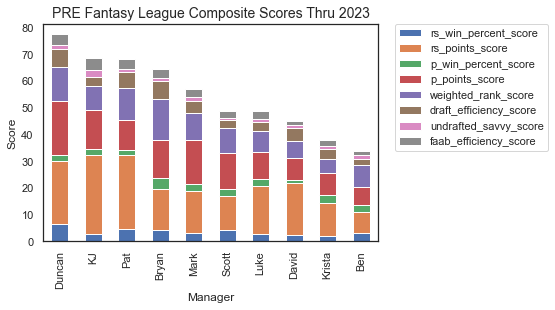

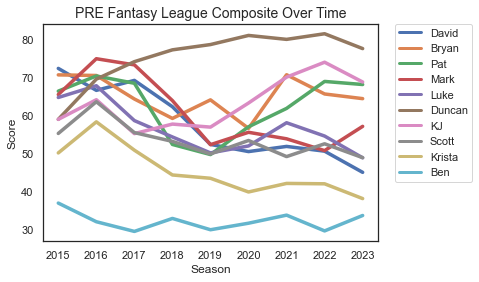

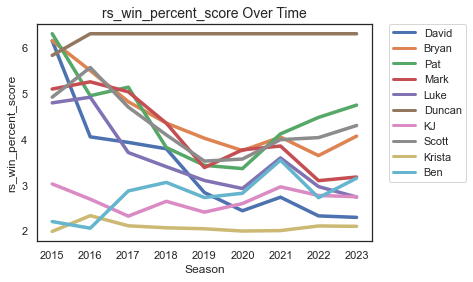

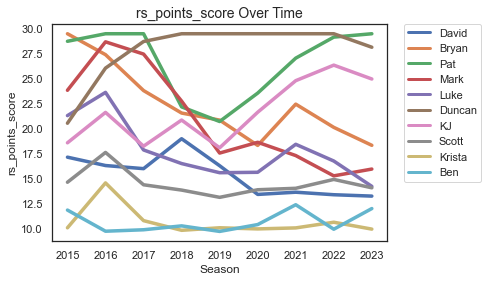

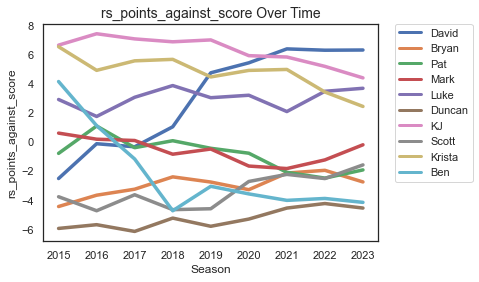

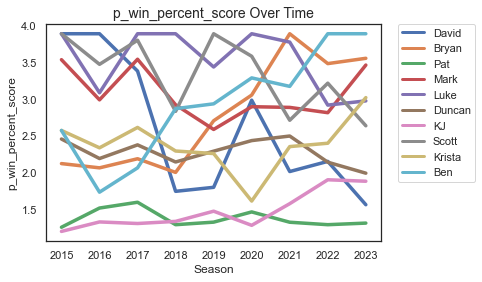

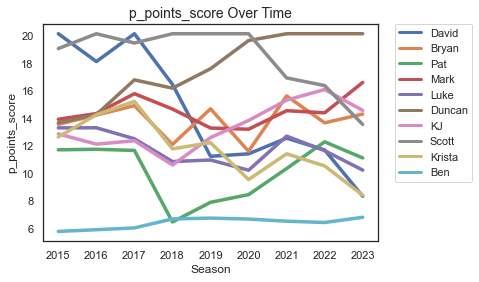

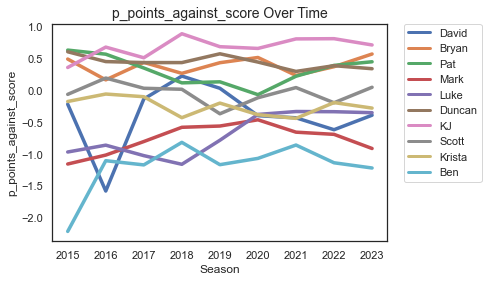

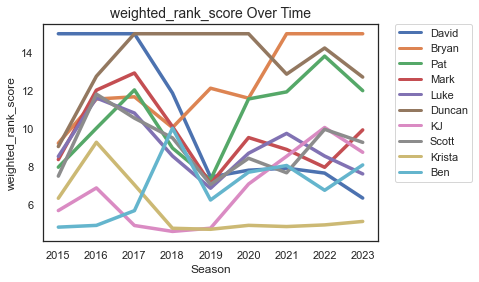

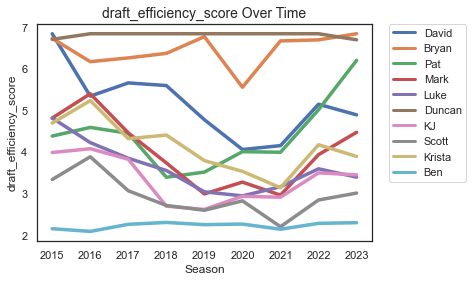

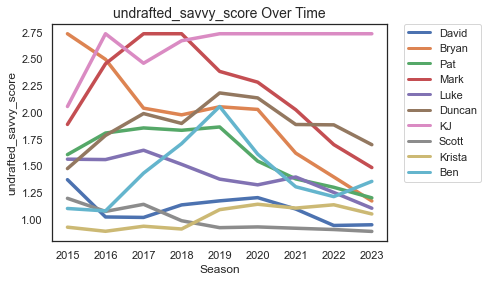

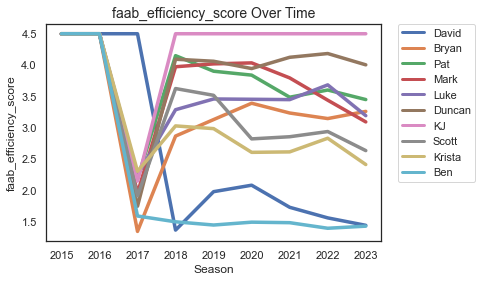

,avg_rs_win_percent,rs_win_percent_score,rs_points_z_score,rs_points_score,rs_points_against_z_score,rs_points_against_score,avg_p_win_percent,p_win_percent_score,p_points_z_score,p_points_score,...,weighted_rank,weighted_rank_score,draft_efficiency,draft_efficiency_score,undrafted_avg_z_score,undrafted_savvy_score,avg_faab_efficiency,faab_efficiency_score,total_score,thru
manager,,,,,,,,,,,,,,,,,,,,,
Duncan,0.586888,6.307101,0.470234,28.174440,-0.503565,-4.538554,0.372489,1.991096,0.311333,20.141871,...,8.750000,12.715798,0.455969,6.698603,0.334794,1.698477,0.296232,4.001605,77.528879,2023
KJ,0.469517,2.748870,0.352523,24.986693,0.489495,4.411749,0.356641,1.881240,0.106649,14.565499,...,7.209375,8.750760,-0.235385,3.452635,0.810922,2.737730,0.266236,4.497699,68.743299,2023
Pat,0.548243,4.749009,0.517937,29.528374,-0.212488,-1.915125,0.261608,1.310250,-0.065326,11.110466,...,8.503125,12.000017,0.372758,6.203722,-0.075713,1.200428,0.333899,3.447354,68.081770,2023
Bryan,0.525137,4.071572,0.075450,18.332174,-0.304276,-2.742390,0.524120,3.557903,0.094260,14.302433,...,9.417857,15.000000,0.479950,6.844325,-0.106153,1.171295,0.348798,3.258487,64.364605,2023
Mark,0.490831,3.178658,-0.059756,15.949733,-0.020802,-0.187482,0.516684,3.465796,0.190665,16.598562,...,7.746875,9.930796,0.038548,4.475131,0.176559,1.484203,0.362962,3.090898,57.075167,2023
Scott,0.533565,4.303423,-0.183628,14.068424,-0.174281,-1.570768,0.442919,2.637938,0.058144,13.549373,...,7.456667,9.273662,-0.380621,3.013706,-0.443354,0.886090,0.403254,2.632953,48.842582,2023
Luke,0.469093,2.741427,-0.172989,14.213783,0.410194,3.697017,0.475657,2.977281,-0.119936,10.225914,...,6.618750,7.611275,-0.253527,3.397023,-0.178826,1.103430,0.354482,3.190382,48.807121,2023
David,0.443764,2.297533,-0.245188,13.235982,0.702217,6.328973,0.307747,1.561002,-0.248415,8.326360,...,5.885000,6.337874,0.135102,4.894729,-0.360966,0.948385,0.535668,1.440420,44.981603,2023
Krista,0.430455,2.102070,-0.522432,9.923768,0.271646,2.448304,0.479882,3.021732,-0.242478,8.399064,...,5.032143,5.105395,-0.107339,3.895493,-0.239994,1.049618,0.426214,2.410654,38.077765,2023


In [21]:
#set parameters
start_year=2015
pre_managers = ['Benjamin','Bryan','David Casstevens','Duncan','Kevin','Krista','Luke','Mark','Patrick','Scott Gunter']
recency_bonus = .15
recency_window = 5 #number of recent seasons that we will give a boost to
use_model_weights=True
manager_controlled_overall_weight=.75
win_percentages_overall_weight=.12
points_against_overall_weight=.13
season_rank_weight=15

#master dictionary we will use to set weights for metrics
Metrics_dict = {
    #metrics getting at effectiveness of player management
    'draft_efficiency':6,
    'faab_efficiency':3,
    'undrafted_savvy':6,
    #rs perormance
    'rs_win_percentage':5,
    'rs_points':38,
    'rs_points_against':8,
    #playoff performance
    'playoff_win_percentage':6,
    'playoff_points':8,
    'playoff_points_against':5,
    #overall
    'season_rank':15,
}

compiled_final_scores, raw_scores = calculate_composite_ranks(Master,start_year,pre_managers,recency_bonus,recency_window,Metrics_dict
                                                              ,use_model_weights,manager_controlled_overall_weight,
                                                              win_percentages_overall_weight,points_against_overall_weight,season_rank_weight)
compiled_final_scores[compiled_final_scores.thru==2023]

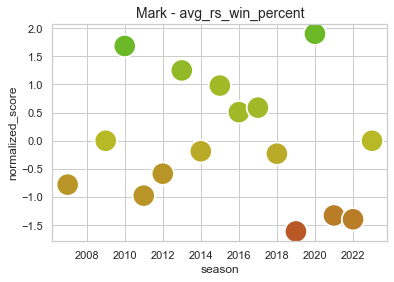

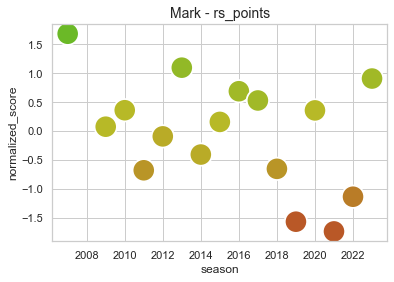

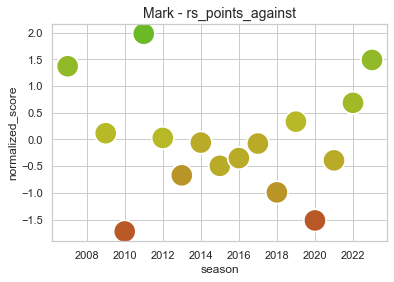

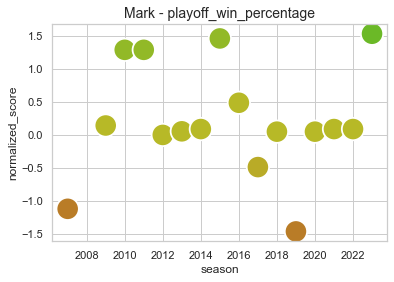

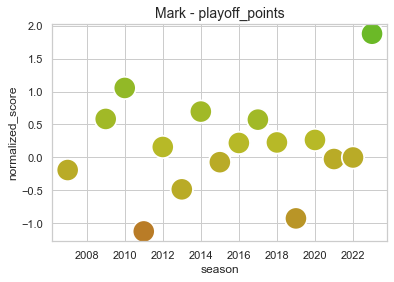

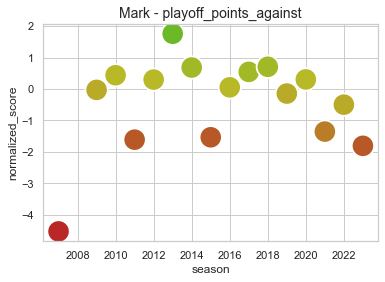

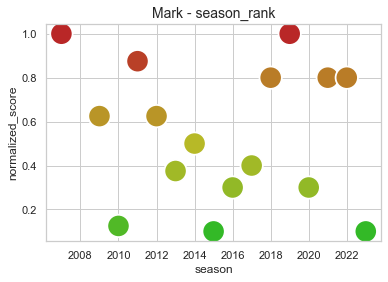

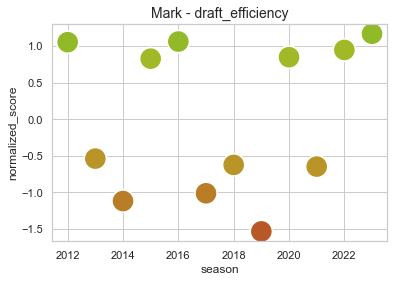

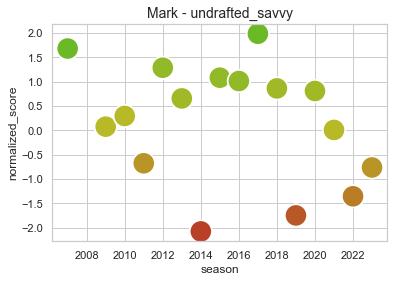

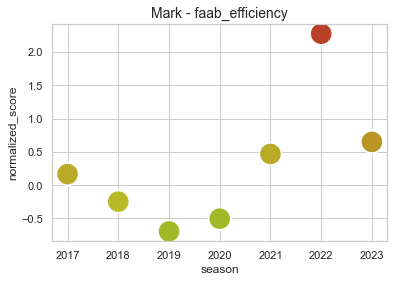

In [20]:
manager_spotlight('Mark',raw_scores)

In [9]:
hue_codes=[]
for index, row in raw_scores.iterrows():
    #if row['metric']=='season_rank':
     #   zscore=
    n=row['normalized_score']
    if n>3:
        hue_codes.append(1)
    elif n>2.5:
        hue_codes.append(2)
    elif n>2:
        hue_codes.append(3)
    elif n>1.5:
        hue_codes.append(4)
    elif n>1:
        hue_codes.append(5)
    elif n>.5:
        hue_codes.append(6)
    elif n>=0:
        hue_codes.append(7)
    elif n>-.5:
        hue_codes.append(8)
    elif n>-1:
        hue_codes.append(9)
    elif n>-1.5:
        hue_codes.append(10)
    elif n>-2:
        hue_codes.append(11)
    elif n>-2.5:
        hue_codes.append(12)
    elif n>-3:
        hue_codes.append(13)
    else:
        hue_codes.append(14)
raw_scores['hue_code']=hue_codes

hue_dict={
    1:'#33b927',
    2:'#47b927',
    3:'#5db927',
    4:'#73b927',
    5:'#89b927',
    6:'#9cb927',
    7:'#abb927',
    8:'#b9b427',
    9:'#b9a327',
    10:'#b99027',
    11:'#b97c27',
    12:'#b96927',
    13:'#b94227',
    14:'#b92727'
}
#this is the way I need to do it:
#dict(setosa="#9b59b6", virginica="#3498db", versicolor="#95a5a6")

In [10]:
raw_scores[(raw_scores.metric=='season_rank')&(raw_scores.manager=='Patrick')]

,season,manager,metric,score,normalized_score,hue_code


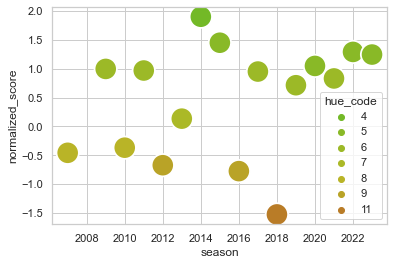

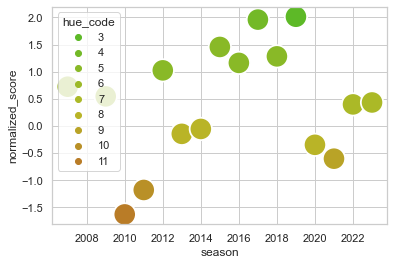

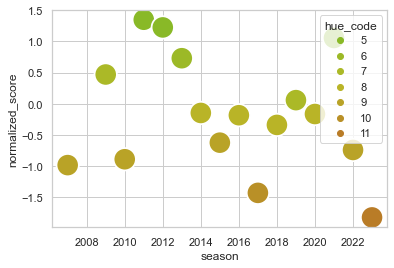

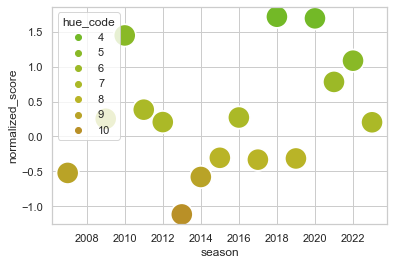

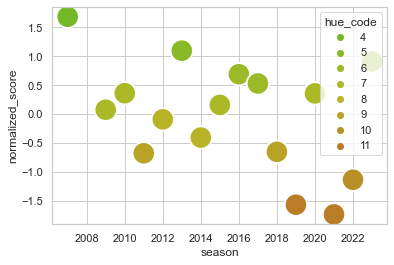

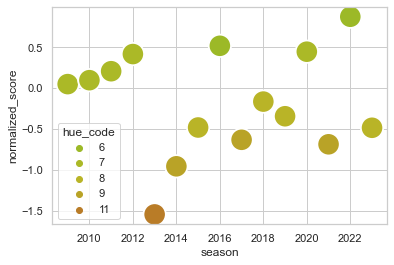

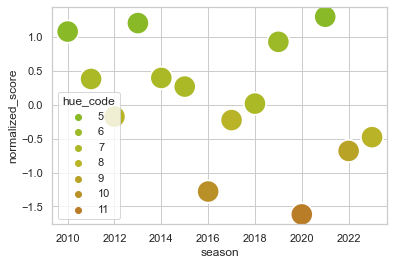

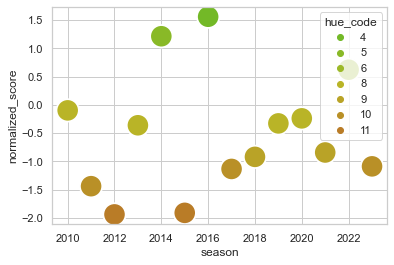

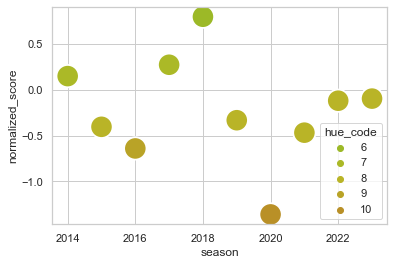

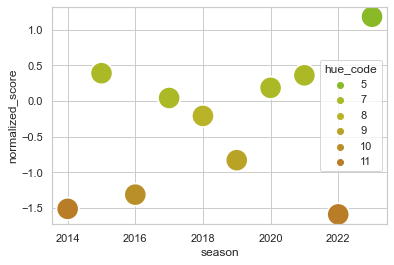

In [11]:
for manager in raw_scores.manager.drop_duplicates():
    manager_metric=raw_scores[(raw_scores.manager==manager)&(raw_scores.metric=='rs_points')]
    size=manager_metric.normalized_score
    sns.scatterplot(x="season",
                    y="normalized_score",
                    data=manager_metric,
                    hue="hue_code",
                    palette=hue_dict,
                    s=500
                    )
    plt.show()

In [12]:
#compile data for modeling
raw_scores_df=pd.DataFrame()
raw_scores_df['season']=raw_seasons
raw_scores_df['manager']=raw_managers
raw_scores_df['metric']=raw_metrics
raw_scores_df['score']=raw_values
raw_scores_df=raw_scores_df.drop_duplicates()

#need to inverse the rank weights
inv_rank_weights_dict={}
for key in rank_weights_dict.keys():
    inv_dict= {v: k for k, v in rank_weights_dict[key].items()}
    inv_rank_weights_dict[key]=inv_dict

normalized_scores=[]
for index, row in raw_scores_df.iterrows():
    if row['metric'] =='avg_rs_win_percent':
        normalized_score = (row['score'] - season_data_dict[row['season']]['win_percent_mean']) / season_data_dict[row['season']]['win_percent_stdev']
    elif row['metric'] =='playoff_win_percentage':
        normalized_score = (row['score'] - season_data_dict[row['season']]['p_win_percents_mean']) / season_data_dict[row['season']]['p_win_percents_stdev']
    elif row['metric'] == 'season_rank':
        print(row['season'])
        number_managers=raw_scores_df[raw_scores_df.season==row['season']].drop_duplicates(subset=['manager']).shape[0]
        if row['season'] == 2007:
            number_managers=6
        elif row['season'] == 2009:
            number_managers=8
        actual_rank=inv_rank_weights_dict[number_managers][row['score']]
        normalized_score=actual_rank/number_managers
    else:
        normalized_score=row['score']
    normalized_scores.append(normalized_score)

raw_scores_df['normalized_score']=normalized_scores
raw_scores_df=raw_scores_df.set_index(['manager','season'])

transformed_dfs=[]
for metric in raw_scores_df.metric.drop_duplicates():
    metric_df=raw_scores_df[raw_scores_df.metric==metric][['normalized_score']]
    metric_df.rename(columns={'normalized_score':metric},inplace=True)
    transformed_dfs.append(metric_df)

transformed_raw_df=pd.concat(transformed_dfs,axis=1)
transformed_raw_df

NameError: name 'raw_seasons' is not defined

In [ ]:
transformed_raw_df.to_csv('transformed_pre_fanasy_data.csv')

In [ ]:
full_faab=pd.read_csv('faab_thru_2022.csv')

#clean the failed_bids column so it is usable
new_bids=[]
for failed_bids in full_faab.failed_bids:
    if isinstance(failed_bids,float):
        new_items=''
    else:
        clean1=failed_bids.replace('[','').replace(']]','').replace(', ',',').split(']')
        new_items=[]
        for failed in clean1:
            failed_items=[]
            for clean2 in failed.split(','):
                if len(clean2)>0:
                    failed_items.append(clean2[1:-1])
            new_items.append(failed_items)
    new_bids.append(new_items)
full_faab['failed_bids_clean'] = new_bids

top_losing_bids=[]
for f in full_faab.failed_bids_clean:
    if len(f)==0:
        top_losing_bids.append(0)
    else:
        top_bid = int(f[0][2].split()[0].replace('$',''))
        top_losing_bids.append(top_bid)
full_faab['top_losing_bid']=top_losing_bids

full_faab['bid_differential'] = full_faab.faab_dollars - full_faab.top_losing_bid

#map manager names based on id
manager_ids=[]
for awardee_url in full_faab.awardee_url:
    manager_id = int(awardee_url.split('/')[-1])
    manager_ids.append(manager_id)
full_faab['manager_id']=manager_ids

season_dfs=[]
for season in full_faab.season.drop_duplicates():
    season_faab_df=full_faab[full_faab.season==season]
    manager_lkup={}
    for index, row in Master[Master.season==season].iterrows():
        manager_id = int(row['team_key'].split('.')[-1])
        manager= row['manager']
        if manager_id not in manager_lkup.keys():
            manager_lkup[manager_id]=manager
    season_faab_df['manager_name'] = season_faab_df.manager_id.map(manager_lkup)
    season_dfs.append(season_faab_df)
full_faab_m=pd.concat(season_dfs)

#meh do it again now to get the actual season scores
#It looks like what I did in the past for this metric is [avg differential of winning bid] + [count bids *.2] + [unused faab *.1]
season_faab_score_dfs=[]
for season in full_faab_m.season.drop_duplicates():
    #print(season)
    season_df=full_faab_m[full_faab_m.season==season]
    manager_faab_dict={}
    for manager in season_df.manager_name.drop_duplicates():
        #print(manager)
        manager_df=season_df[season_df.manager_name==manager]
        avg_differential=manager_df.bid_differential.sum() / manager_df.shape[0]
        unused_dollars=100-manager_df.faab_dollars.sum()
        faab_efficiency=avg_differential+(unused_dollars*.1)+(manager_df.shape[0]*.2)
        manager_faab_dict[manager] =faab_efficiency
        #print(f'avg_differential: {avg_differential}')
        #print(f'unused: {unused_dollars}')
        #print(f'faab_efficiency: {faab_efficiency}')
    manager_faab_df=pd.DataFrame(index=manager_faab_dict.keys())
    manager_faab_df['faab_efficiency']=manager_faab_dict.values()
    season_faab_stdev=stats.stdev(manager_faab_df.faab_efficiency)
    season_faab_mean=manager_faab_df.faab_efficiency.sum() / manager_faab_df.shape[0]
    manager_faab_df['faab_efficiency_zscore'] = (manager_faab_df.faab_efficiency-season_faab_mean) / season_faab_stdev
    manager_faab_df['season']=season
    #update season_data_dict
    season_data_dict[season]['faab_efficiency_stdev'] =season_faab_stdev
    season_data_dict[season]['faab_efficiency_mean'] = season_faab_mean
    season_faab_score_dfs.append(manager_faab_df)

full_season_faab_dfs=pd.concat(season_faab_score_dfs)

faab_efficiency_dict = {}
for manager in pre_managers:
    manager_faab_scores = []
    manager_df = full_season_faab_dfs[full_season_faab_dfs.index==manager]
    for index, row in manager_df.iterrows():
        if row['season'] < (latest_season - recency_window):
            raw_faab_efficiency_score=row['faab_efficiency_zscore']
            manager_faab_scores.append(raw_faab_efficiency_score)
        else:
            faab_efficiency_zscore = row['faab_efficiency_zscore']
            score_modifier = faab_efficiency_zscore * recency_bonus
            modified_score = (faab_efficiency_zscore + score_modifier) * season_data_dict[season]['faab_efficiency_stdev'] + season_data_dict[season]['faab_efficiency_mean']
            manager_faab_scores.append(modified_score)
    avg_faab_efficiency = sum(manager_faab_scores) / len(manager_faab_scores)
    faab_efficiency_dict[manager] = avg_faab_efficiency

faab_efficiency_score_dict = create_metric_dict(faab_efficiency_dict.values(),'faab_efficiency',True)
final_scores_df['avg_faab_efficiency'] = final_scores_df.index.map(faab_efficiency_dict)
final_scores_df['faab_efficiency_score'] = final_scores_df.avg_faab_efficiency.map(faab_efficiency_score_dict)

final_scores_df


,avg_rs_win_percent,rs_win_percent_score,rs_points_z_score,rs_points_score,rs_points_against_z_score,rs_points_against_score,avg_p_win_percent,p_win_percent_score,p_points_z_score,p_points_score,...,weighted_rank,weighted_rank_score,draft_efficiency,draft_efficiency_score,undrafted_avg_z_score,undrafted_savvy_score,total_score,thru,avg_faab_efficiency,faab_efficiency_score
Duncan,0.596691,5.000000,0.503632,38.000000,-0.484863,-3.878901,0.379153,3.052883,0.351345,8.000000,...,8.773333,14.359744,7.265538,6.000000,0.393071,4.227817,75.728410,2022,7.366770,2.187318
Kevin,0.472027,2.164336,0.372548,33.337488,0.585366,4.682925,0.373282,2.994737,0.166620,6.310829,...,7.666667,10.227967,3.615691,2.954664,0.759662,6.000000,70.675747,2022,6.805133,3.000000
Patrick,0.550085,3.604089,0.477459,37.050040,-0.306183,-2.449465,0.265574,2.035675,-0.061966,4.811165,...,8.800000,14.460000,5.853379,4.596663,-0.107598,2.711471,67.742403,2022,8.113126,1.462409
Bryan,0.513440,2.815906,0.119819,25.290146,-0.216068,-1.728543,0.529950,5.145520,0.014361,5.271028,...,8.938462,15.000000,6.876638,5.587205,-0.047221,2.850117,61.239460,2022,8.154114,1.433498
Luke,0.490659,2.431632,-0.004794,22.280063,0.429587,3.436695,0.432204,3.656879,-0.114669,4.521331,...,7.385714,9.480838,3.818170,3.064432,-0.132915,2.656162,51.313491,2022,7.957313,1.581246
David Casstevens,0.445177,1.816227,-0.262177,17.199238,0.729426,5.835407,0.330886,2.582887,-0.118752,4.500227,...,6.555556,7.575211,5.987606,4.708469,-0.481489,1.967184,44.839345,2022,7.894139,1.630941
Mark,0.489963,2.421494,-0.142026,19.359695,-0.143489,-1.147914,0.451044,3.894916,0.065588,5.598868,...,6.760000,8.000481,4.400780,3.415433,0.235986,3.692726,43.562870,2022,8.459326,1.223461
Scott Gunter,0.514078,2.826705,-0.213945,18.029846,-0.237741,-1.901924,0.508659,4.790153,0.093511,5.783456,...,7.040000,8.628646,2.579565,2.413079,-0.303358,2.295928,41.648549,2022,8.878407,0.982154
Krista,0.429755,1.648437,-0.490498,13.448476,0.398976,3.191809,0.412464,3.422717,-0.203915,4.062160,...,5.092308,4.797432,4.383884,3.405224,-0.306302,2.290483,35.766182,2022,8.449255,1.229433
Benjamin,0.474237,2.193373,-0.543342,12.769699,-0.466404,-3.731228,0.573853,6.000000,-0.523520,2.578173,...,6.400000,7.268836,1.612865,2.000403,-0.150042,2.619509,28.773568,2022,8.517752,1.188983


In [ ]:
faab_efficiency_dict

{'Benjamin': 7.326291203916711,
 'Bryan': 7.326291203916711,
 'David Casstevens': 7.326291203916711,
 'Duncan': 7.326291203916711,
 'Kevin': 7.326291203916711,
 'Krista': 7.326291203916711,
 'Luke': 7.326291203916711,
 'Mark': 7.326291203916711,
 'Patrick': 7.326291203916711,
 'Scott Gunter': 7.326291203916711}

In [ ]:
full_season_faab_dfs[full_season_faab_dfs.season==2020].sort_values(by=['faab_efficiency'])

,faab_efficiency,season
Bryan,5.400000,2020
Mark,6.857143,2020
Luke,6.907692,2020
Kevin,6.929412,2020
David Casstevens,7.061538,2020
Patrick,7.333333,2020
Benjamin,7.785714,2020
Duncan,7.822222,2020
Krista,9.754545,2020
Scott Gunter,12.122222,2020


In [ ]:
full_faab_m.manager_id.iloc[0]

'3'

In [ ]:
#playoffs cleanup
managers=[]
opponents=[]
p_2020 = pd.read_csv('2020_pre_playoffs.csv')
manager_lkup={}
for index, row in Master[Master.season==2020].iterrows():
    manager_id = int(row['team_key'].split('.')[-1])
    manager= row['manager']
    if manager_id not in manager_lkup.keys():
        manager_lkup[manager_id]=manager
p_2020['manager_name']=p_2020.manager_id.map(manager_lkup)
p_2020['opponent_name']=p_2020.opponent_id.map(manager_lkup)

p_2020.to_csv('p_2020.csv')


In [ ]:
#in season pickups
#this code will produce the df of all rs matchups and append a flag for whether the player was drafted by the corresponding manager
#it gets saved to file because it takes a bit of time to compute, probably because I am doing it inefficiently but eh
rs_matchup_datas=[]
for season in master.season.drop_duplicates():
    rs_matchups_df = pd.read_csv(f'{season}_pre_matchups.csv')
    rs_matchups_df['season'] = season
    manager_key_dict={}
    for index, row in master[master.season==season].iterrows():
        team_key = int(row['team_key'].split('.')[-1])
        manager_key_dict[team_key] = row['manager']
    rs_matchups_df['manager_name'] = rs_matchups_df.manager_id.map(manager_key_dict)
    player_ids=[]
    for index, row in rs_matchups_df.iterrows():
        try:
            if row['player_url'][-1]=='/':
                url=row['player_url'][:-1]
                player_id=url.split('/')[-1]
            else:
                player_id=row['player_url'].split('/')[-1]
            player_ids.append(player_id)
        except:
            player_ids.append('')
    rs_matchups_df['player_id'] = player_ids
    is_drafted=[]
    for index, row in rs_matchups_df.iterrows():
        #for each row check if they are drafted by the corresponding manager
        filter_df = full_seasons_draft_df[(full_seasons_draft_df.Year==season) & (full_seasons_draft_df.player_id==row['player_id']) & (full_seasons_draft_df.Owner==row['manager_name'])]
        filter_rows=filter_df.shape[0]
        if filter_rows>0:
            if filter_rows==1:
                is_drafted.append(1)
            else:
                print(filter_df)
        else:
            is_drafted.append(0)
    rs_matchups_df['is_drafted'] = is_drafted
    rs_matchup_datas.append(rs_matchups_df)

full_rs_matchups_df=pd.concat(rs_matchup_datas)

full_rs_matchups_df

,Unnamed: 0,position,manager_id,opponent_id,matchup_url,player,player_url,score,manager,league_url,season,manager_name,player_id,is_drafted
0,0,QB,1,2,https://football.fantasysports.yahoo.com//2007...,D. McNabb,https://sports.yahoo.com/nfl/players/4650,7,Philadelphia Freedom,https://football.fantasysports.yahoo.com/2007/...,2007,Ryan,4650,0
1,1,WR,1,2,https://football.fantasysports.yahoo.com//2007...,M. Harrison,https://sports.yahoo.com,10,Philadelphia Freedom,https://football.fantasysports.yahoo.com/2007/...,2007,Ryan,sports.yahoo.com,0
2,2,WR,1,2,https://football.fantasysports.yahoo.com//2007...,C. Johnson,https://sports.yahoo.com/nfl/players/5483,10,Philadelphia Freedom,https://football.fantasysports.yahoo.com/2007/...,2007,Ryan,5483,0
3,3,WR,1,2,https://football.fantasysports.yahoo.com//2007...,J. Walker,https://sports.yahoo.com/nfl/players/5906,5,Philadelphia Freedom,https://football.fantasysports.yahoo.com/2007/...,2007,Ryan,5906,0
4,4,RB,1,2,https://football.fantasysports.yahoo.com//2007...,L. Tomlinson,https://sports.yahoo.com/nfl/players/5452,15,Philadelphia Freedom,https://football.fantasysports.yahoo.com/2007/...,2007,Ryan,5452,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,6,TE,10,5,https://football.fantasysports.yahoo.com//f1/7...,P. Freiermuth Pit - TE,https://sports.yahoo.com/nfl/players/33443,11.63,Fresh Princ(ess) of Helaire,https://football.fantasysports.yahoo.com/2022/...,2022,Krista,33443,0
1536,7,W/R/T,10,5,https://football.fantasysports.yahoo.com//f1/7...,D. Swift Det - RB,https://sports.yahoo.com/nfl/players/32705,6.38,Fresh Princ(ess) of Helaire,https://football.fantasysports.yahoo.com/2022/...,2022,Krista,32705,1
1537,8,Q/WR/T,10,5,https://football.fantasysports.yahoo.com//f1/7...,M. Jones NE - QB,https://sports.yahoo.com/nfl/players/33403,9.63,Fresh Princ(ess) of Helaire,https://football.fantasysports.yahoo.com/2022/...,2022,Krista,33403,1
1538,9,DEF,10,5,https://football.fantasysports.yahoo.com//f1/7...,Philadelphia Phi - DEF,https://sports.yahoo.com/nfl/teams/philadelphia/,19.0,Fresh Princ(ess) of Helaire,https://football.fantasysports.yahoo.com/2022/...,2022,Krista,philadelphia,1


In [ ]:
#saving this to file because this step takes a bit of time and would be annoying to have to recalculate
full_rs_matchups_df.to_csv('full_rs_matchups_w_is_drafted.csv',index=False)

In [ ]:
full_rs_matchups_df=pd.read_csv('full_rs_matchups_w_is_drafted.csv')
non_drafted_avg_scores =[]
for season in master.season.drop_duplicates():
    manager_avg_scores={}
    season_matchups = full_rs_matchups_df[full_rs_matchups_df.season==season]
    for manager in season_matchups.manager_name.drop_duplicates():
        manager_non_drafted = season_matchups[(season_matchups.manager_name==manager) & (season_matchups.is_drafted==0)]
        cleaned_scores=[]
        for score in manager_non_drafted.score:
            if score=='–':
                cleaned_scores.append(0)
            else:
                cleaned_scores.append(score)
        manager_non_drafted['score'] = cleaned_scores
        manager_non_drafted['score'] = manager_non_drafted['score'].astype(float)
        avg_score = manager_non_drafted.score.sum() / manager_non_drafted.shape[0]
        manager_avg_scores[manager]=avg_score
    df=pd.DataFrame(index=manager_avg_scores.keys(),data=manager_avg_scores.values(),columns=['avg_non_draft_score'])
    stdev=stats.stdev(df.avg_non_draft_score)
    m= df.avg_non_draft_score.sum() / df.shape[0]
    zscores=[]
    for v in df.avg_non_draft_score:
        zscore=(v-m)/stdev
        zscores.append(zscore)
    df['zscore_non_draft_scores'] =zscores
    df['season']= season
    non_drafted_avg_scores.append(df)
full_non_drafted_avg_scores=pd.concat(non_drafted_avg_scores)

rs_non_drafted_dict = {}
for manager in pre_managers:
    manager_z_scores = []
    manager_df = full_non_drafted_avg_scores[full_non_drafted_avg_scores.index==manager]
    for index, row in manager_df.iterrows():
        if row['season'] < (latest_season - recency_window):
            manager_z_scores.append(row['zscore_non_draft_scores'])
        else:
            modified_score = row['zscore_non_draft_scores'] * (1 + recency_bonus)
            manager_z_scores.append(modified_score)
    avg_rs_non_drafted_points = sum(manager_z_scores) / len(manager_z_scores)
    rs_non_drafted_dict[manager] = avg_rs_non_drafted_points

non_drafted_score_dict = create_metric_dict(rs_non_drafted_dict.values(),'undrafted_savvy',False)
final_scores_df['undrafted_avg_z_score'] = final_scores_df.index.map(rs_non_drafted_dict)
final_scores_df['undrafted_savvy_score'] = final_scores_df.undrafted_avg_z_score.map(non_drafted_score_dict)

final_scores_df


KeyError: 'undrafted_savvy'

In [ ]:
df=pd.DataFrame(index=manager_avg_scores.keys(),data=manager_avg_scores.values(),columns=['avg_non_draft_score'])
stdev=stats.stdev(df.avg_non_draft_score)
m= df.avg_non_draft_score.sum() / df.shape[0]
zscores=[]
for v in df.avg_non_draft_score:
    zscore=(v-m)/stdev
    zscores.append(zscore)
df['zscore_non_draft_scores'] =zscores
df

,avg_non_draft_score,zscore_non_draft_scores
Scott Gunter,12.530299,0.264064
Benjamin,11.531613,-0.157267
Duncan,15.066267,1.333952
Luke,10.393220,-0.637539
Mark,8.696000,-1.353572
David Casstevens,9.393077,-1.059485
Patrick,12.214462,0.130817
Bryan,9.770750,-0.900150
Kevin,15.273243,1.421273
Krista,14.174923,0.957907
